In [1]:
import sys
import math
import sympy as sy
from uncertainties import ufloat
from scipy import stats
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from scipy.stats import binom, poisson, norm 
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r'/home/saim/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [2]:
# Plotting stuff
plt.rcParams['font.size'] = 18 
plt.style.use(['science', 'notebook', 'grid'])

pink = '#e377c2'
blue = '#1f77b4'
golden = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
purple = '#9467bd'
light_blue = '#17becf'

In [3]:
r = np.random
r.seed(42)

N_points = 10000     # Number of random points produced
x_all = r.normal(loc = 0.2, 
                 scale = 1.1, 
                 size = N_points)

Nbins = 100
binwidth_gauss = np.ptp(x_all) / Nbins
x_min, x_max = np.min(x_all), np.max(x_all)

In [4]:
# Fitting function
#def func_gaussian_llh(x, N, mu, sigma) :
    #return N * norm.pdf(x, mu, sigma)

# Fitting function which is NOT normalised but has normalisation constants "N" in, 
# and includes the bin width:

def func_gauss_norm(x, N, mu, sigma) :
    norm = binwidth_gauss * N / np.sqrt(2.0 * np.pi) / sigma
    z = (x - mu) / sigma
    
    return norm * np.exp(-0.5 * (z**2))

# Fitting function which is NOT normalised but has normalisation constants "N" in, 
# but does NOT includes the bin width:

def func_gauss_llh(x, N, mu, sigma) :
    norm = N / np.sqrt(2.0 * np.pi) / sigma
    z = (x - mu) / sigma
    
    return norm * np.exp(-0.5 * (z**2))

In [15]:
def MLE_hist(data, Nbins, mini, maxi):
    
    counts, bin_edges = np.histogram(data, 
                                     bins = Nbins, 
                                     range = (mini, maxi), 
                                     density = False)

    x = (bin_edges[1:] + bin_edges[:-1]) / 2
    y = counts
    sy = np.sqrt(y)
    
    return x, y, sy

x1, y1, sy1 = MLE_hist(x_all, Nbins, x_min, x_max)

print(np.mean(x_all), np.std(x_all))

0.19765041829473118 1.1037534267429865


In [6]:
# extended=True because we have our own normalization in our fit function
bllh_object_fit = BinnedLH(func_gauss_llh, 
                           x_all, 
                           bins = Nbins,
                           extended = True)

                           
minuit_fit_bllh = Minuit(bllh_object_fit, 
                         N = N_points, 
                         mu = 0.204, 
                         sigma = 1)

minuit_fit_bllh.errordef = Minuit.LIKELIHOOD
minuit_fit_bllh.migrad()

/home/saim/External_Functions/ExternalFunctions.py:277: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 49.23                      │         Nfcn = 44 (44 total)         │
│ EDM = 2.52e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  10.0e3   │   0.1e3   │            │            │         │         │       │
│ 1 │ mu    │   0.198   │   0.011   │            │            │         │         │       │
│ 2 │ sigma │   1.105   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

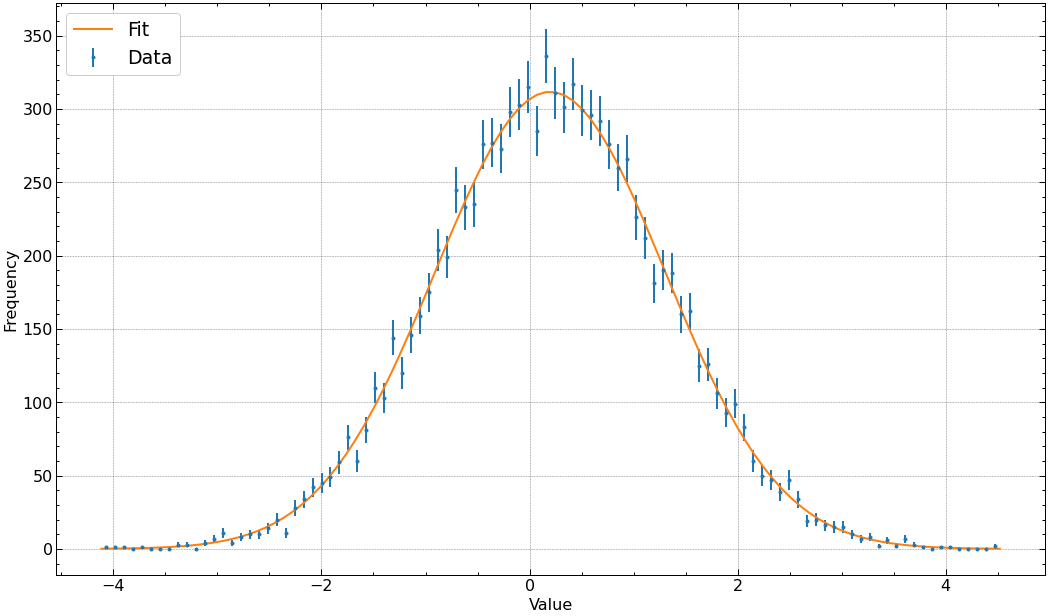

In [7]:
# Produce the points for drawing the fit:
xaxis_bllh = np.linspace(x_min, x_max, Nbins)
yaxis_bllh = func_gauss_norm(xaxis_bllh, *minuit_fit_bllh.values[:])

# Init plot object
fig, ax = plt.subplots(figsize=(15, 9))

ax.errorbar(x1, y1, sy1, fmt = '.', color = blue, label = 'Data')
ax.plot(xaxis_bllh, yaxis_bllh, '-', color = golden, label = 'Fit')

ax.set(xlabel = "Value", 
       ylabel = "Frequency", 
       title = "")

ax.legend(loc = 'upper left', fontsize=19);
fig.tight_layout()

In [8]:
# TODO
# Try all with various functional forms

In [9]:
ullhfit = UnbinnedLH(func_gauss_llh, 
                     x_all, 
                     bound = (x_min, x_max), 
                     extended = True)


minuit_fit_ullh = Minuit(ullhfit, 
                     N = N_points, 
                     mu = 0.204, 
                     sigma = 1)

minuit_fit_ullh.errordef = Minuit.LIKELIHOOD  
minuit_fit_ullh.migrad()           # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -6.693e+04                 │         Nfcn = 46 (46 total)         │
│ EDM = 2.75e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  10.0e3   │   0.1e3   │            │            │         │         │       │
│ 1 │ mu    │   0.198   │   0.011   │            │            │         │         │       │
│ 2 │ sigma │   1.105   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

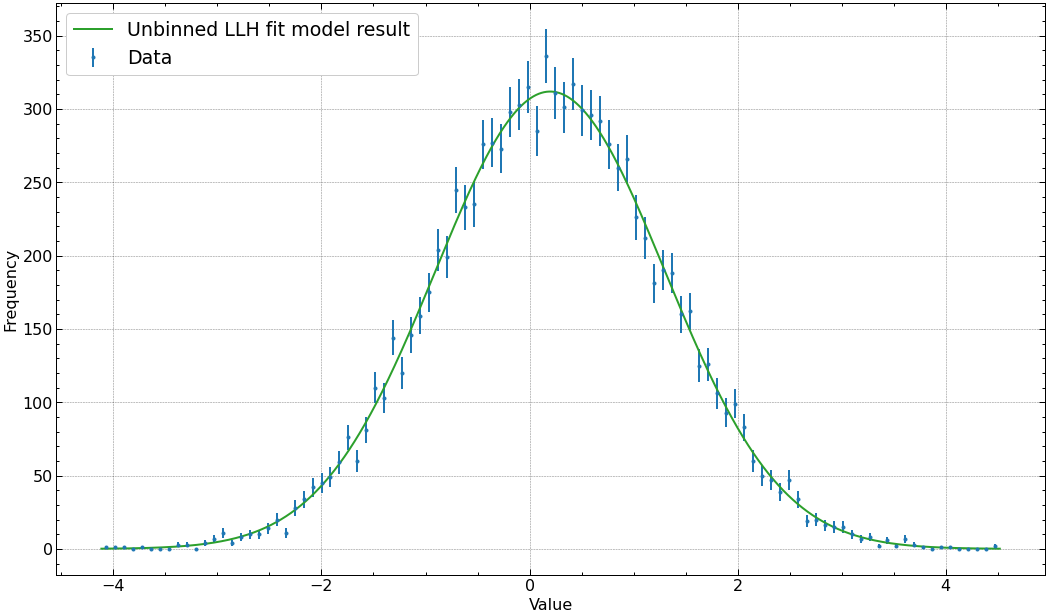

In [10]:
# Produce the points for drawing the fit:
xaxis_ullh = np.linspace(x_min, x_max, N_points)
yaxis_ullh = func_gauss_norm(xaxis_ullh, *minuit_fit_ullh.values[:])

# Init plot object
fig, ax = plt.subplots(figsize=(15, 9))

ax.errorbar(x1, y1, sy1, fmt = '.', color = blue, label = 'Data')

ax.plot(xaxis_ullh, 
        yaxis_ullh, 
        '-g', 
        label = 'Unbinned LLH fit model result', 
        color = green) 


ax.set(xlabel = "Value", 
       ylabel = "Frequency", 
       title = "")

ax.legend(loc = 'upper left', fontsize=19);
fig.tight_layout()

In [18]:
print(*minuit_fit_ullh.values[:])

10001.115740347039 0.19771011351981246 1.1045541341503253


In [173]:
# Fit exp, power, T-dist, double gauss

## Exponential Fit

In [11]:
N_exp = 10000     # Number of random points produced
x_exp = r.exponential(np.e, N_exp)

exp_bins = 100
binwidth_exp = np.ptp(x_exp) / exp_bins
exp_min, exp_max = np.min(x_exp), np.max(x_exp)

In [12]:
def exp_pdf(x, N, tau):
    return N * binwidth_exp / tau * np.exp(-x/tau)

def exp_pdf_llh(x, N, tau):
    return N / tau * np.exp(-x/tau)

In [13]:
# extended=True because we have our own normalization in our fit function
bllh_exp_object = BinnedLH(exp_pdf_llh, 
                           x_exp, 
                           bins = exp_bins,
                           extended = True)

                           
exp_fitted_bllh = Minuit(bllh_exp_object, 
                         N = N_exp, 
                         tau = 2.5)

exp_fitted_bllh.errordef = Minuit.LIKELIHOOD
exp_fitted_bllh.migrad()

/home/saim/External_Functions/ExternalFunctions.py:277: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 47.69                      │         Nfcn = 32 (32 total)         │
│ EDM = 5.05e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │  10.0e3   │   0.1e3   │            │            │         │         │       │
│ 1 │ tau  │   2.792   │   0.028   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [14]:
# Produce the points for drawing the fit:
exp_x_ax = np.linspace(exp_min, exp_max)
exp_y_ax = exp_pdf(exp_x_ax, *exp_fitted_bllh.values[:])

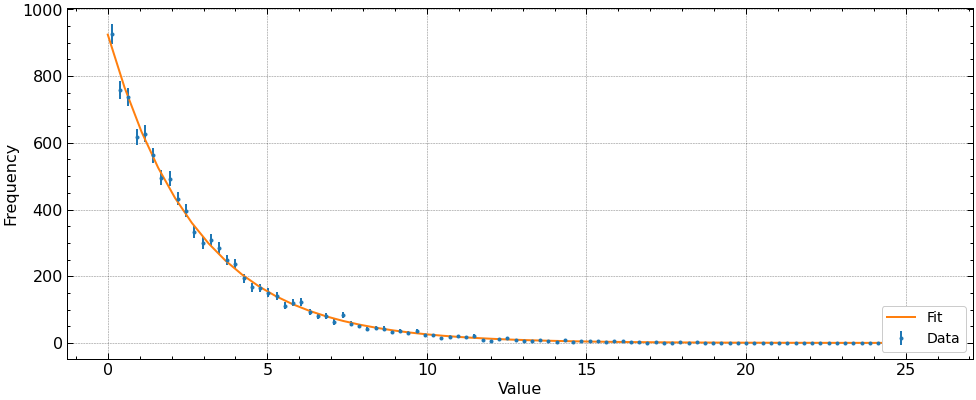

In [16]:
# Produce figure with histogram (with error bars) and fit overlayed:
fig, ax = plt.subplots(figsize=(14, 6))

# Binning data and plotting it
x2, y2, sy2 = MLE_hist(x_exp, exp_bins, exp_min, exp_max)
ax.errorbar(x2, y2, sy2, fmt = '.', color = blue, label = 'Data')

ax.plot(exp_x_ax, exp_y_ax, '-', color = golden, label = 'Fit')

ax.set(xlabel = "Value", 
       ylabel = "Frequency", 
       title = "")

ax.legend(loc = 'lower right', 
          fontsize=14);

fig.tight_layout()

In [ ]:
# REMEMBER THAT LLH DOES NOT CARE ABOUT ZERO BINS